In [1]:
import sklearn
import pandas as pd

# Importing processed data (feature engineered)

In [2]:
import pickle

with open('yk_dataframes.pkl', 'rb') as file:
    data = pickle.load(file)

yk_full = data['yk_full']
yk_dropped = data['yk_dropped']


with open('ty_dataframes.pkl', 'rb') as file:
    data = pickle.load(file)

ty_full = data['ty_full']
ty_dropped = data['ty_dropped']

df_full = pd.concat([yk_full, ty_full], axis=0)

# Importing test values (before feature engineer)

In [3]:
with open('yk_values_dataframe.pkl', 'rb') as file:
    yk_values = pickle.load(file)

with open('ty_values_dataframe.pkl', 'rb') as file:
    ty_values = pickle.load(file)

## Discrete tests to look at qqplot

In [43]:
test = yk_values.T[yk_values.T['Distribution Type'] == 'discrete']
test = test.iloc[:,2:].T

In [22]:
yk_target = yk_values.loc['Distribution Type'].apply(lambda x: 1 if x in ['longtail', 'outlier'] else 0)

ty_target = ty_values.loc['Distribution Type'].apply(lambda x: 1 if x in ['longtail', 'outlier'] else 0)

In [7]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def classify_qq_outliers(data, outlier_threshold=2, long_tail_threshold=2):
    
    data = pd.to_numeric(data , errors='coerce').dropna()

    if np.std(data) < 1e-8: # data is nearly constant
        return 0, 0

    # comparing to theoretical distribution
    (osm, osr), (slope, intercept, r) = stats.probplot(data, dist="norm", plot=None)
    
    # calculate deviation from the theoretical line
    theoretical_line = slope * osm + intercept
    deviations = osr - theoretical_line
    
    # identify outliers: points that deviate significantly from the line
    outliers = np.abs(deviations) > outlier_threshold * np.std(deviations)
    
    # identify long-tail behavior: consistent deviation in the tails
    long_tail_upper = deviations > long_tail_threshold * np.std(deviations)
    long_tail_lower = deviations < -long_tail_threshold * np.std(deviations)
    long_tail = long_tail_upper | long_tail_lower

    both_outlier_and_long_tail = outliers & long_tail

    plt.figure(figsize=(9, 5))
    plt.plot(osm, osr, 'o', label="Sample Quantiles")
    plt.plot(osm, theoretical_line, 'r--', label="Theoretical Quantiles")
    plt.scatter(osm[outliers], osr[outliers], color='orange', label="Outliers", zorder=5)
    plt.scatter(osm[long_tail], osr[long_tail], color='green', label="Long Tail", zorder=5)
    plt.scatter(osm[both_outlier_and_long_tail], osr[both_outlier_and_long_tail], color='purple', label="Both Outlier and Long Tail", zorder=5)
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.legend()
    plt.title("QQ Plot with Outlier and Long-Tail Classification")
    plt.show()

    outliers_count = np.sum(outliers)
    longtail_count = np.sum(long_tail)

    return outliers_count, longtail_count

In [5]:
def qq_predict(data, threshold, ot, lt):
    preds = []
    for col in data:
        values = data[col]
        outliers, longtail = classify_qq_outliers(values, ot, lt)
        total = outliers + longtail
        if total > threshold:
            preds.append(1)
        else:
            preds.append(0)
    return preds

In [27]:
yk_values.iloc[2:, :3]

,0,1,2,3,4
1,25.0,22332.0,1.0,NaN,NaN
2,25.0,11976.0,2.0,NaN,NaN
3,25.0,11920.0,3.0,NaN,NaN
4,25.0,9224.0,4.0,NaN,NaN
5,25.0,11936.0,5.0,NaN,NaN
...,...,...,...,...,...
69573,25.0,12648.0,317.0,NaN,NaN
69574,25.0,12648.0,318.0,NaN,NaN
69575,25.0,12648.0,319.0,NaN,NaN
69576,25.0,4375.0,320.0,NaN,NaN


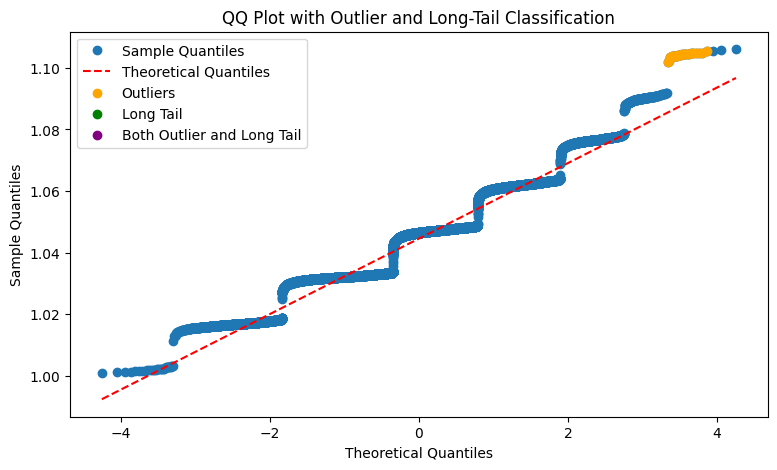

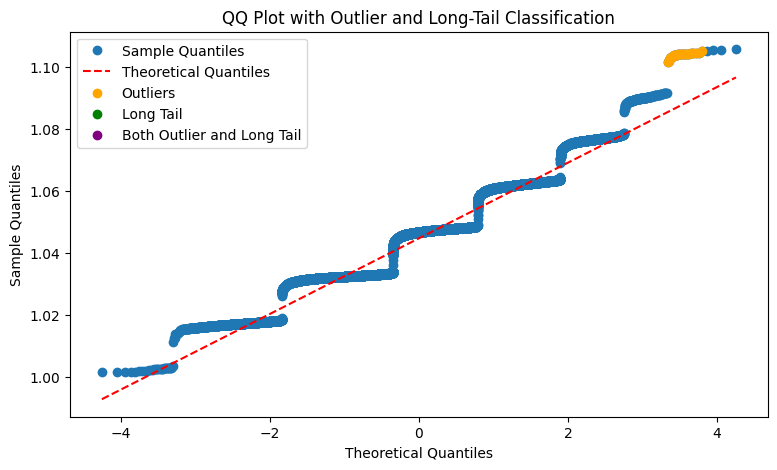

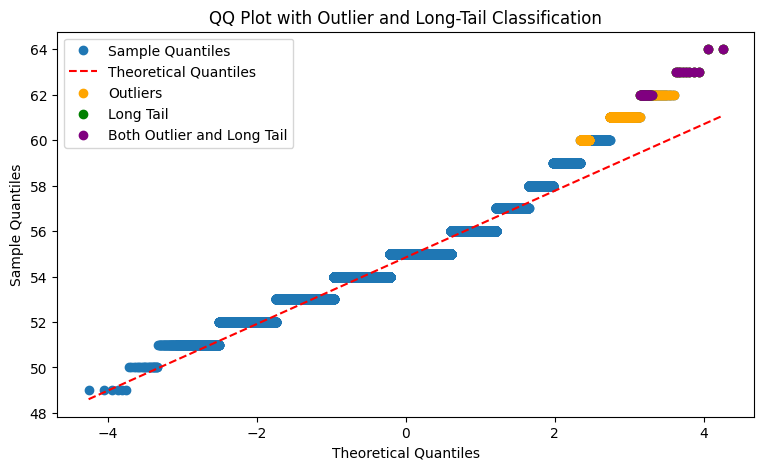

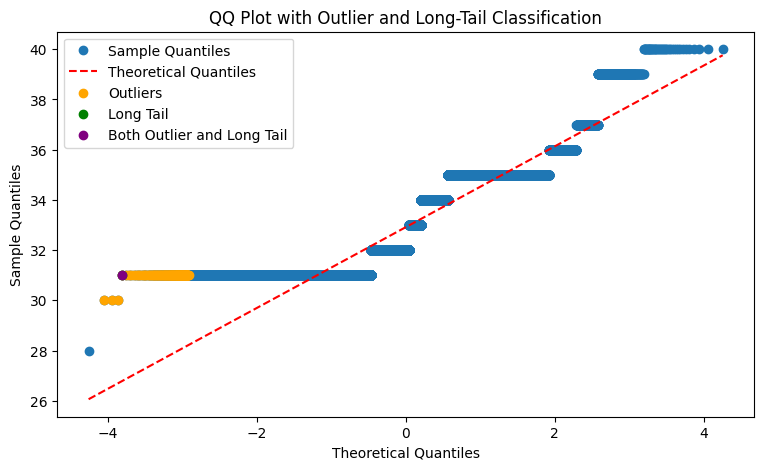

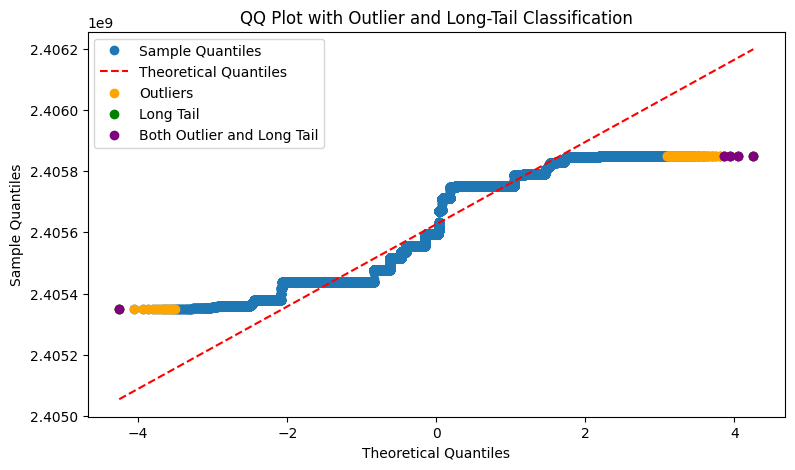

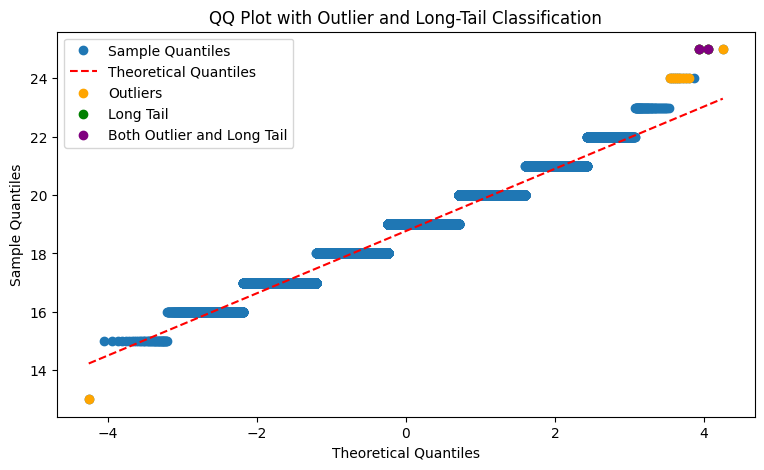

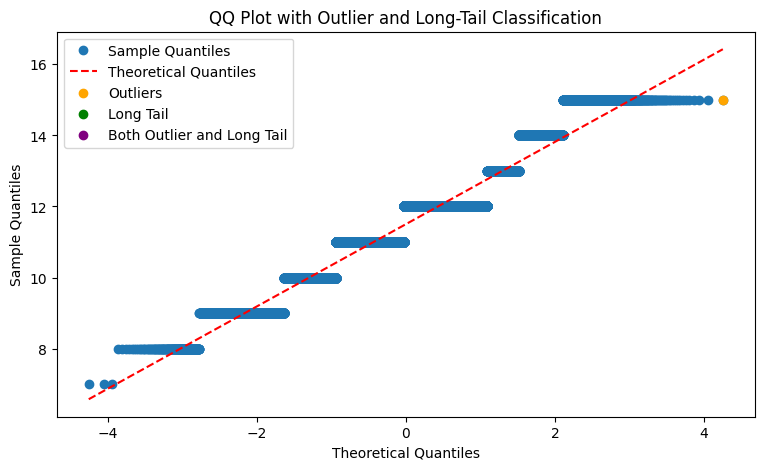

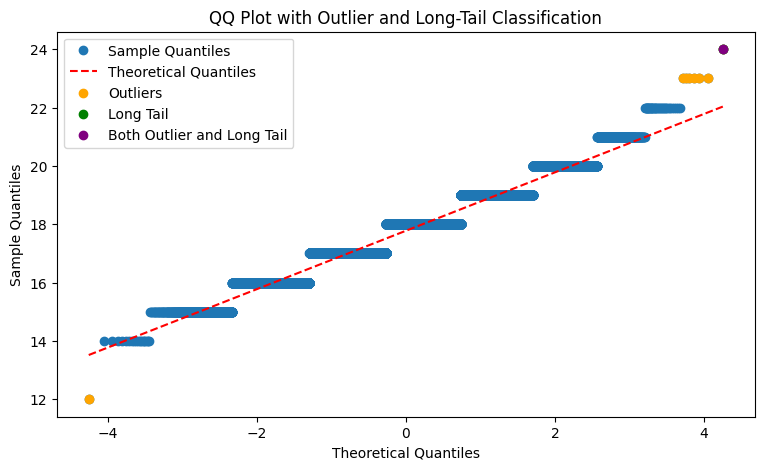

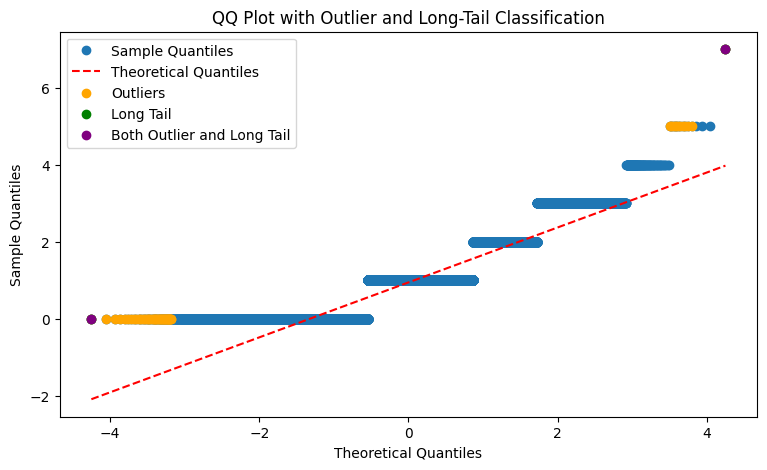

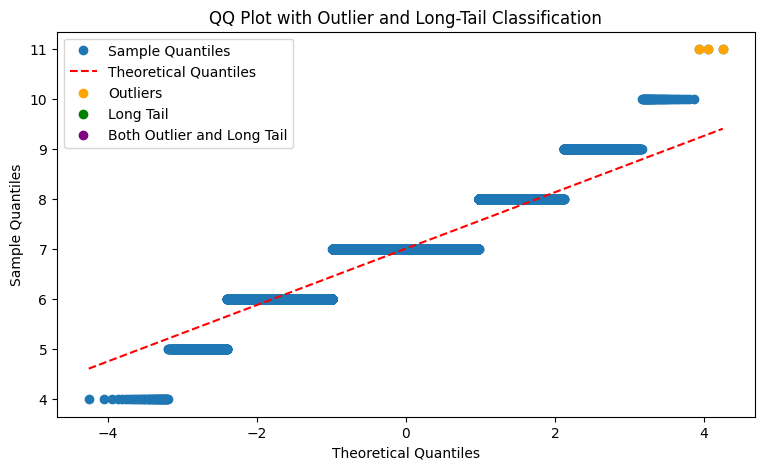

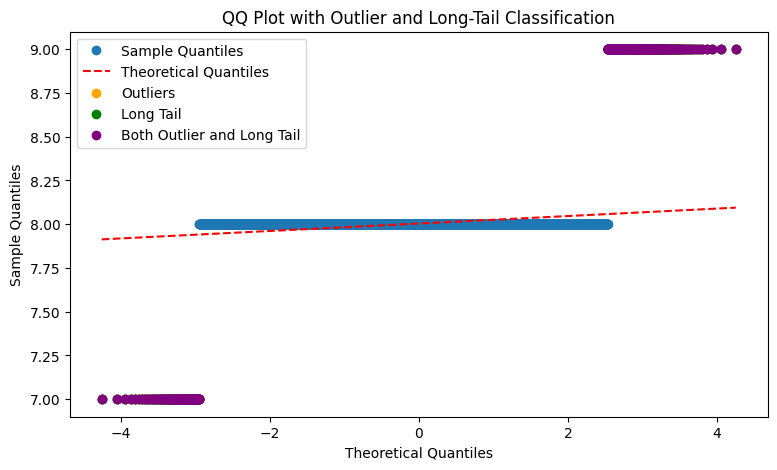

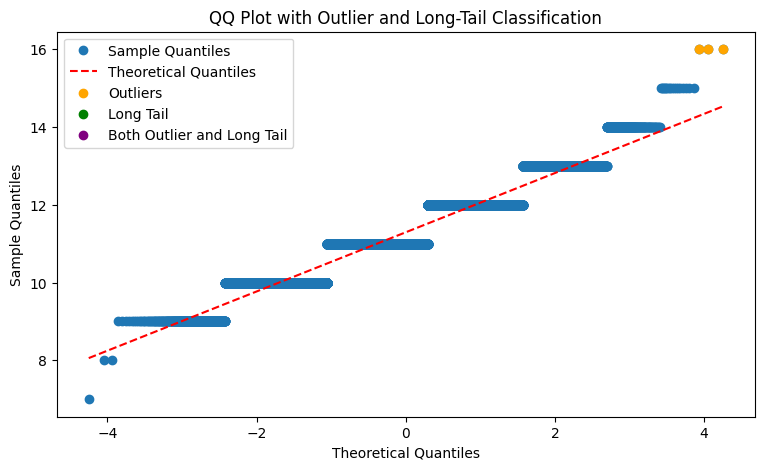

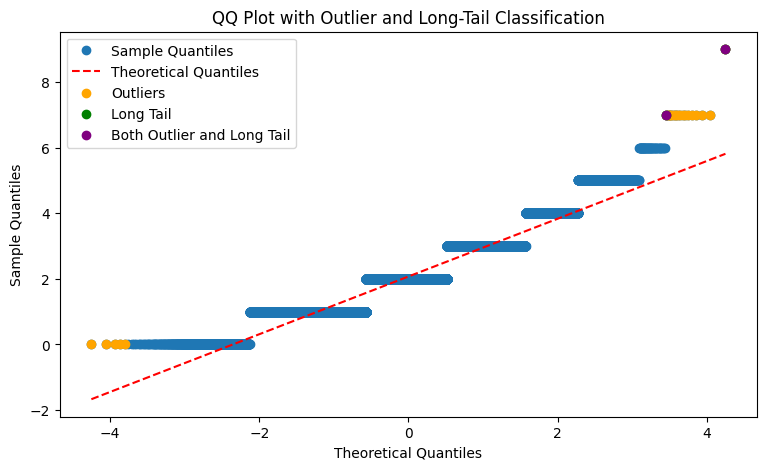

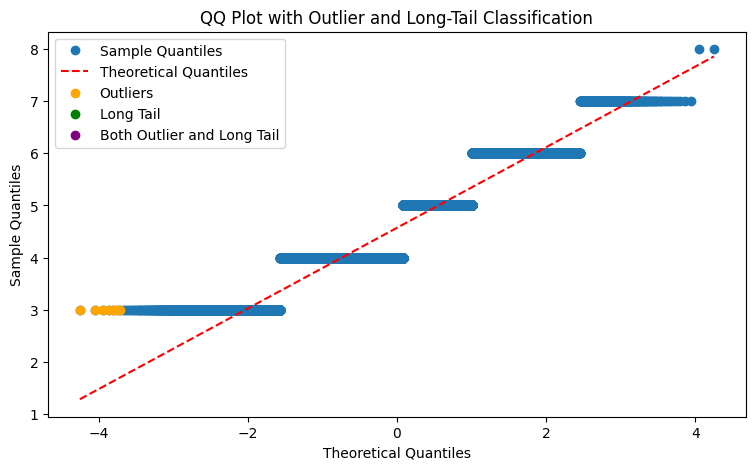

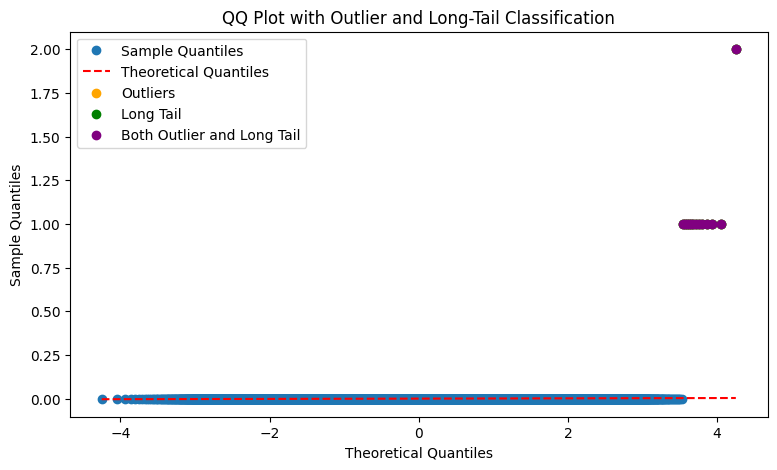

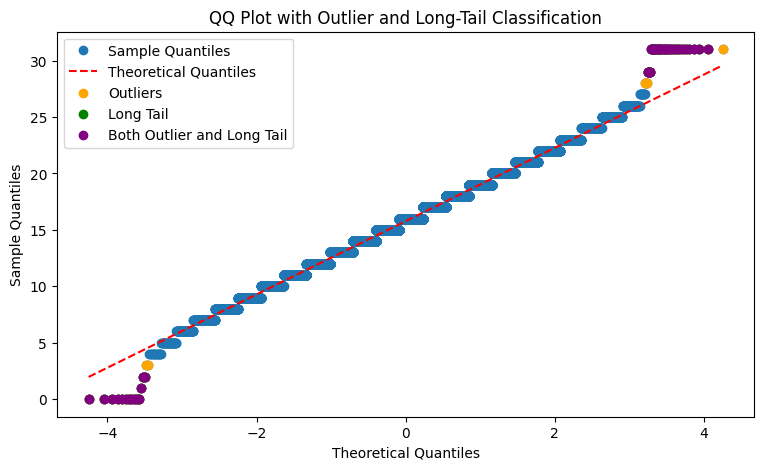

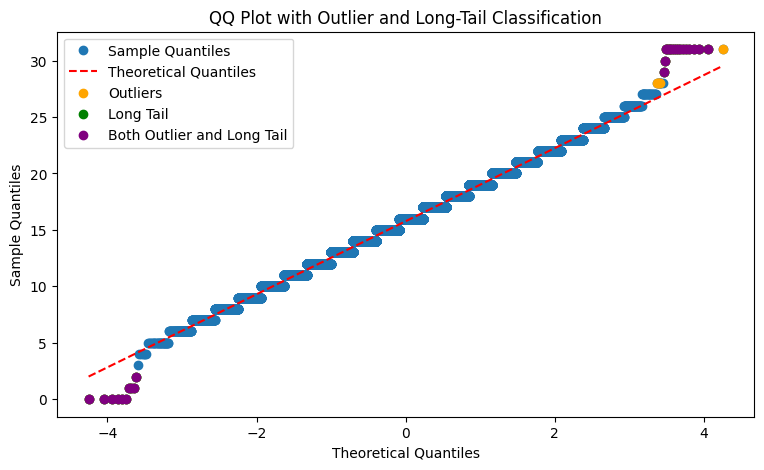

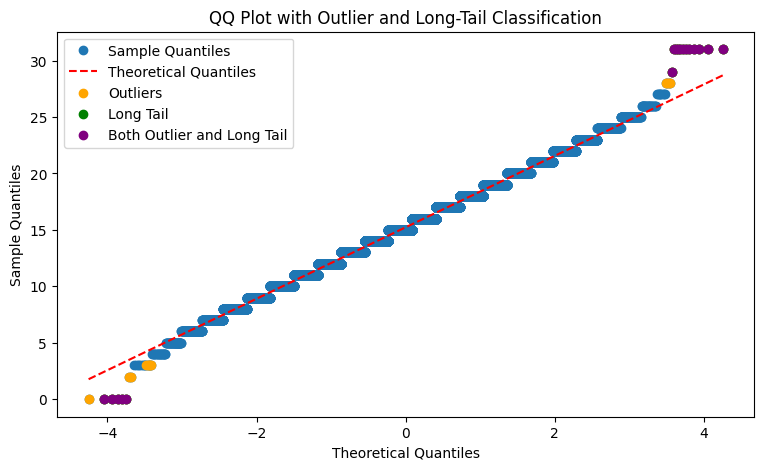

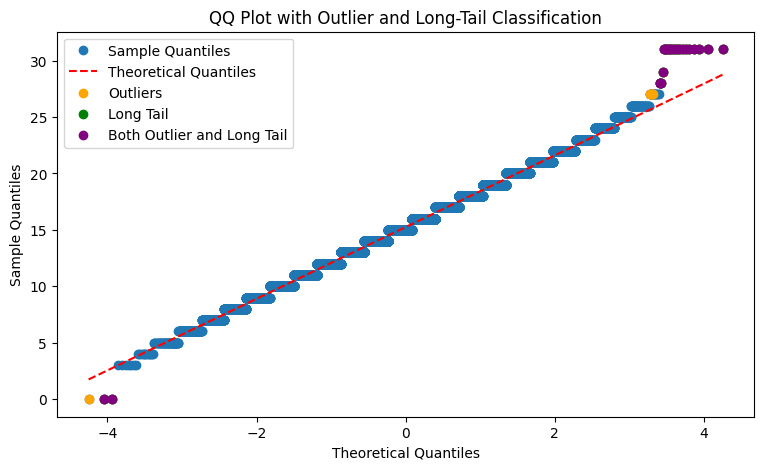

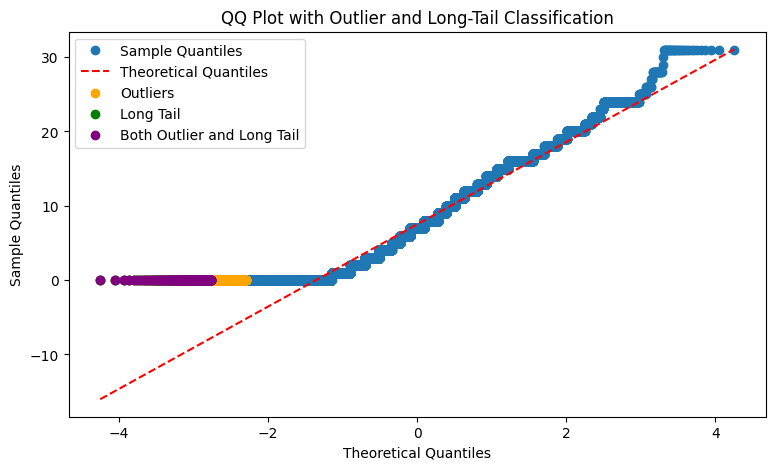

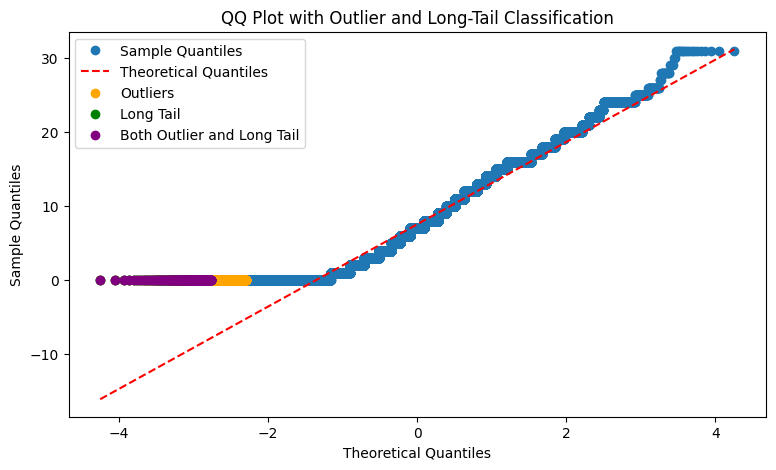

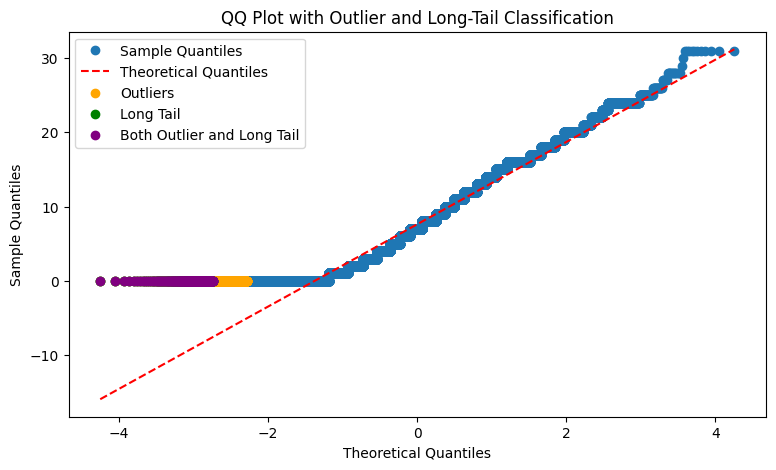

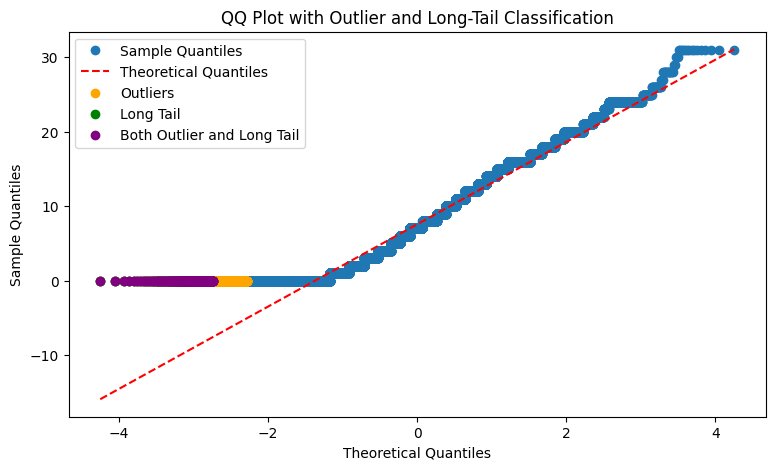

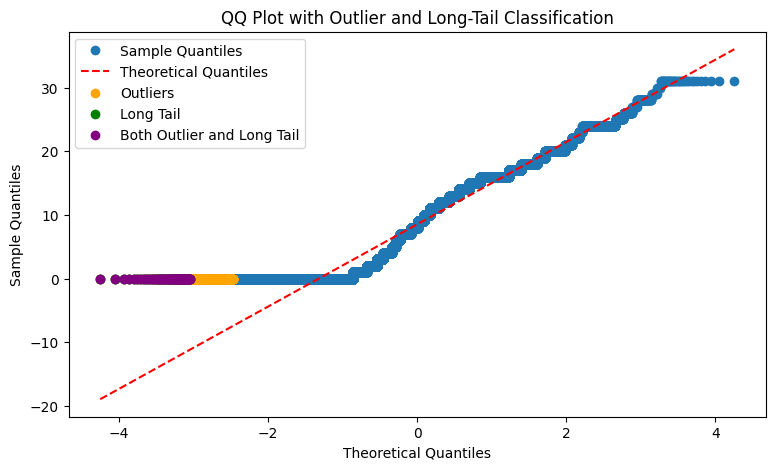

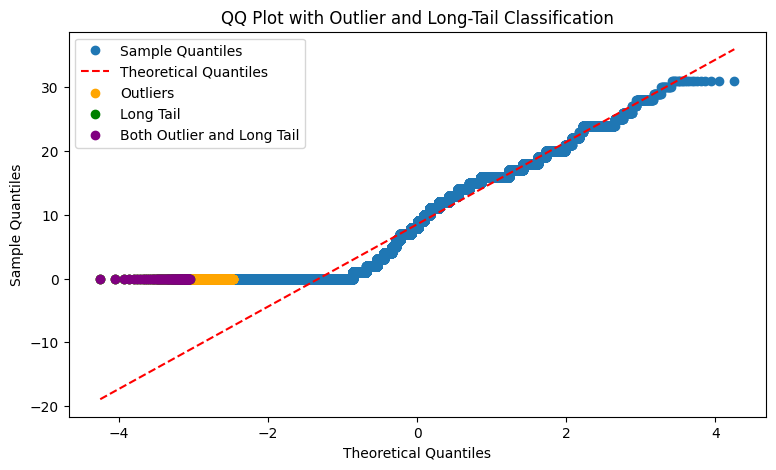

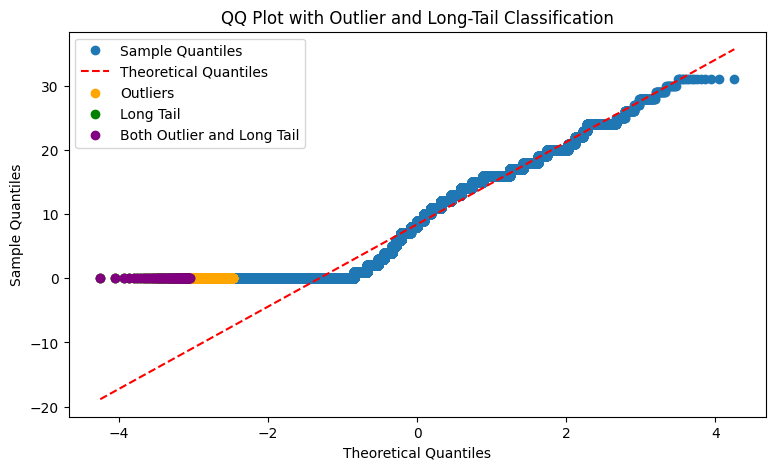

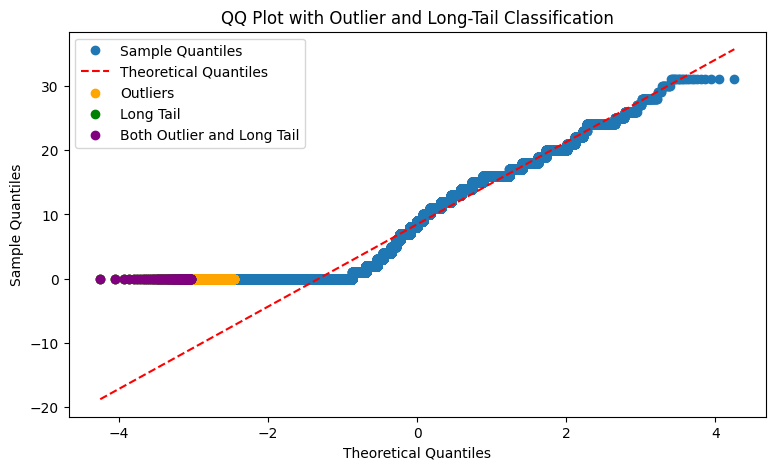

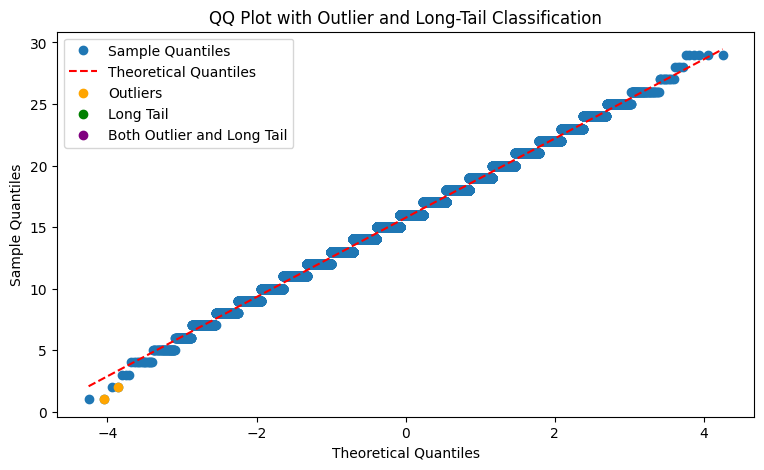

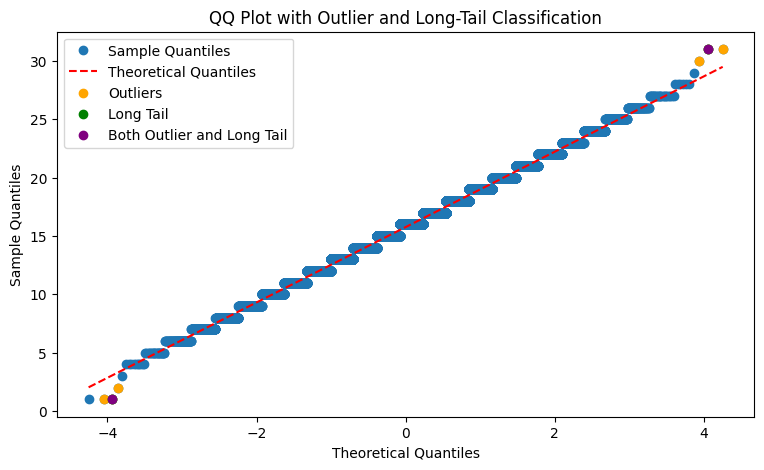

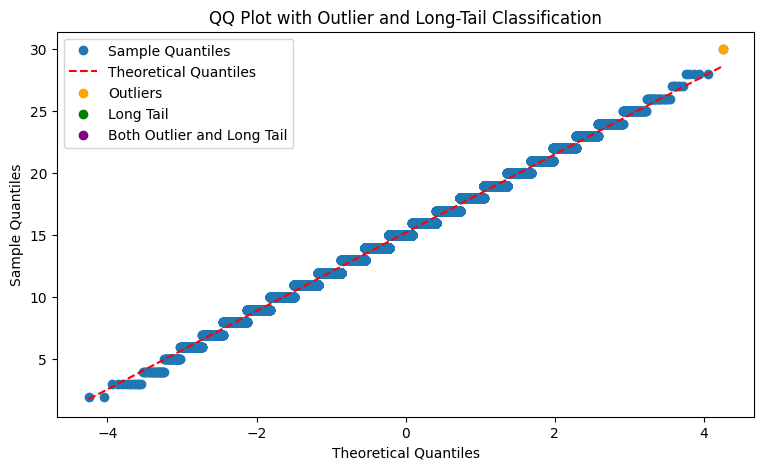

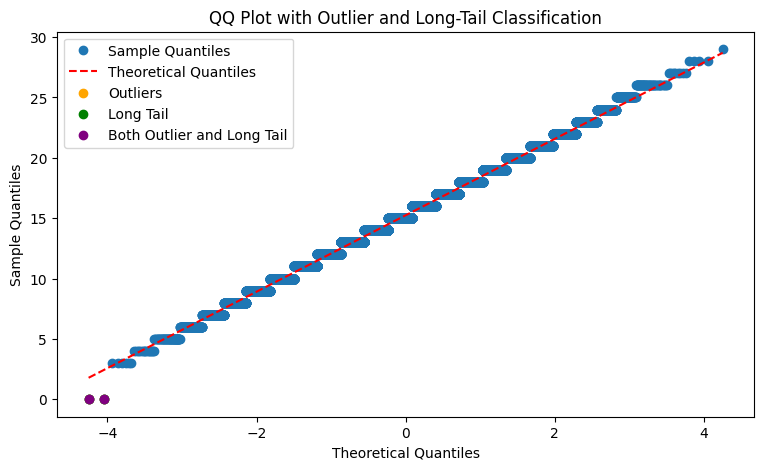

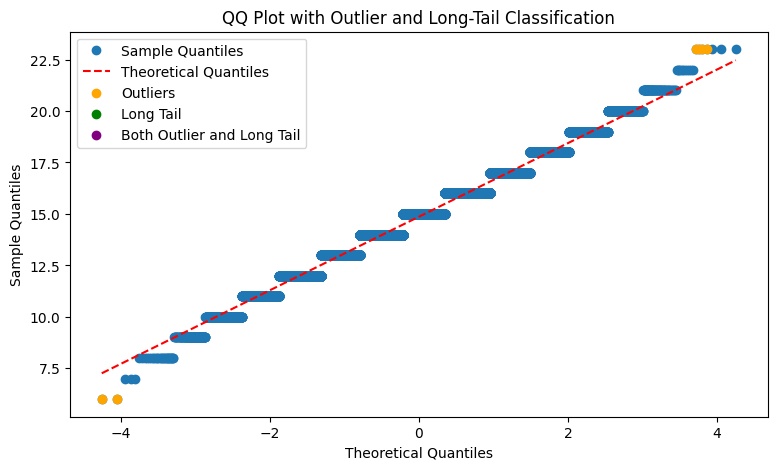

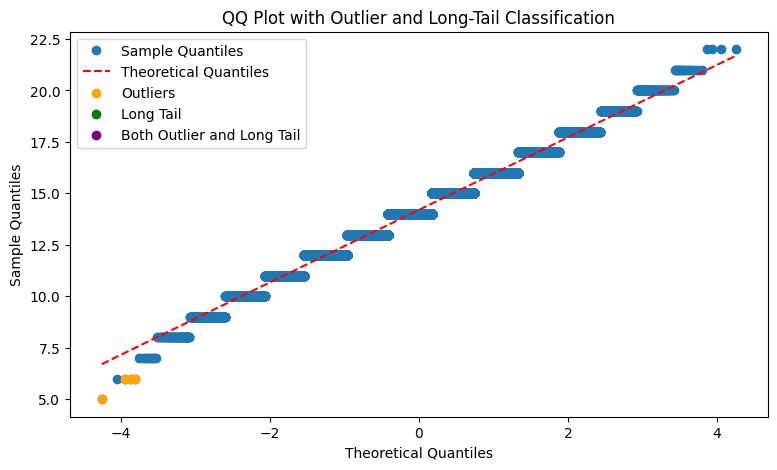

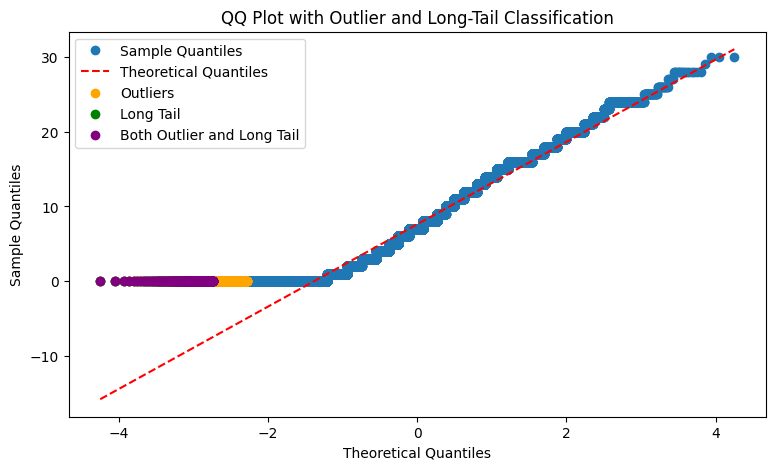

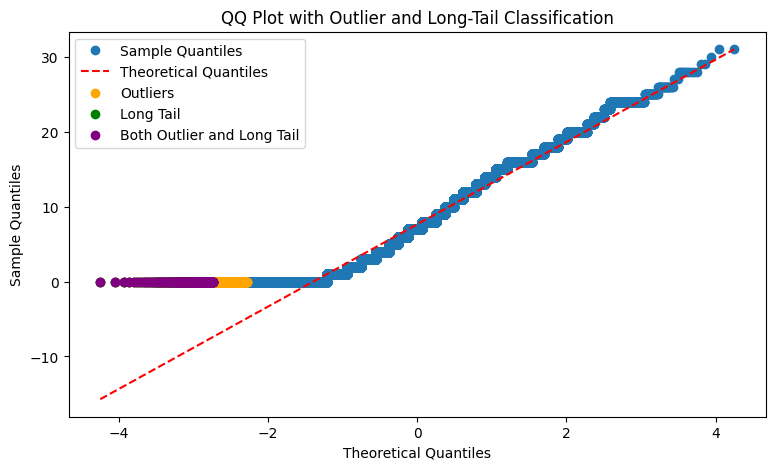

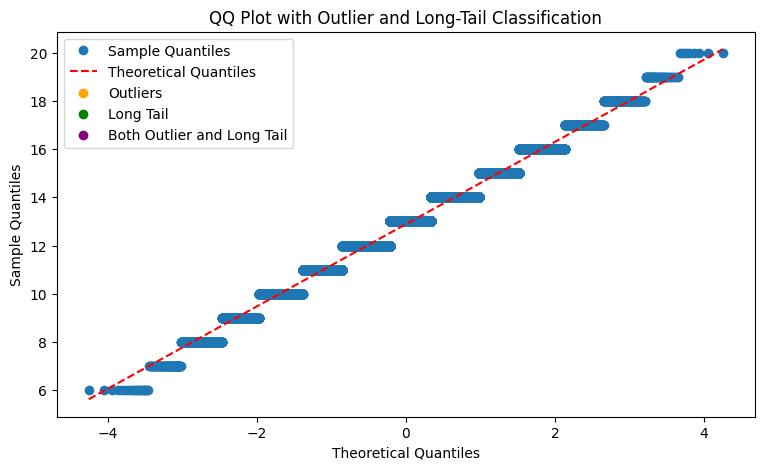

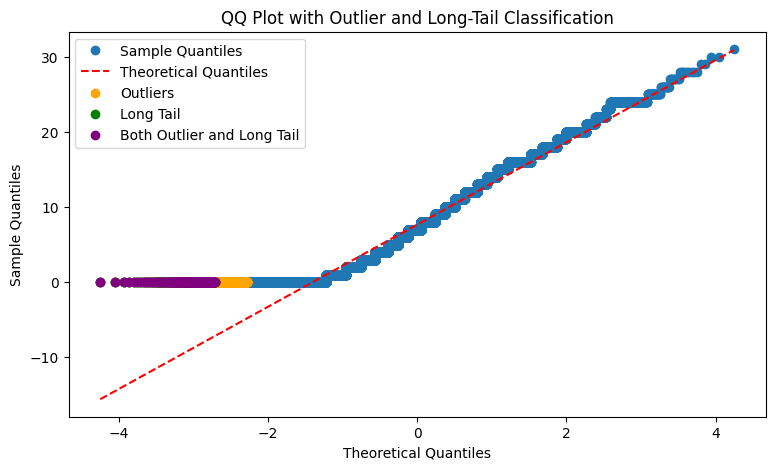

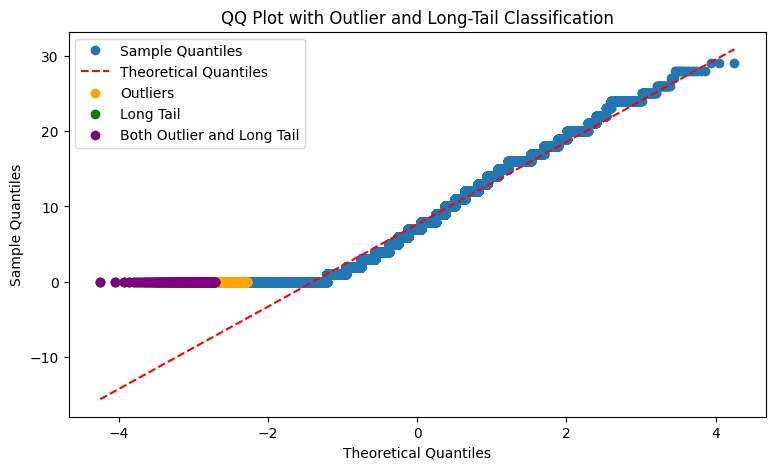

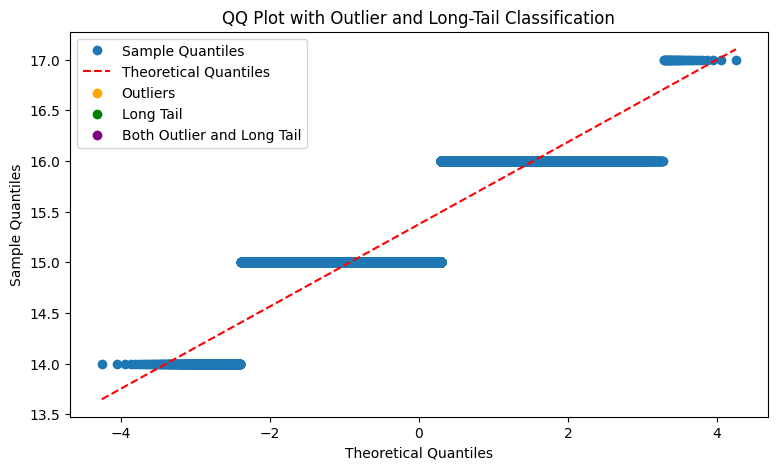

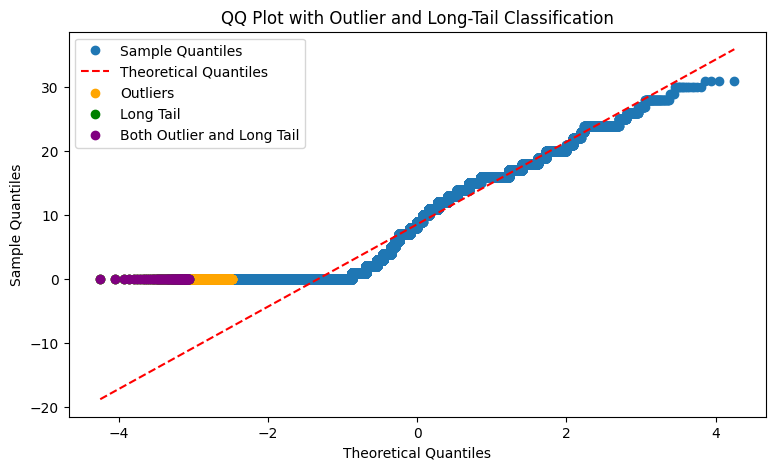

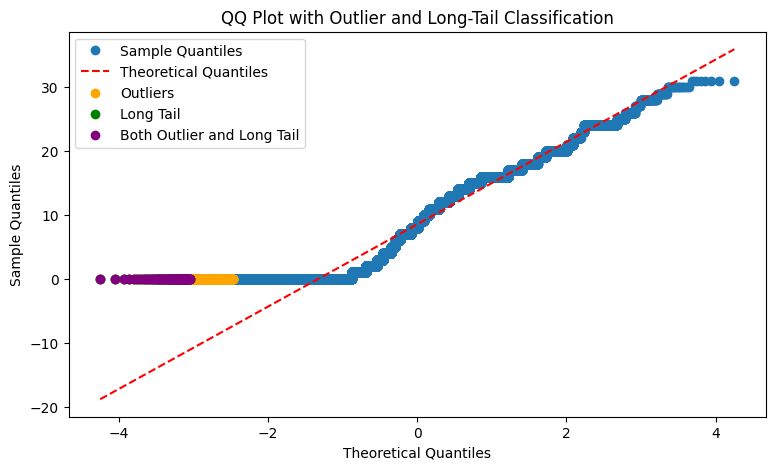

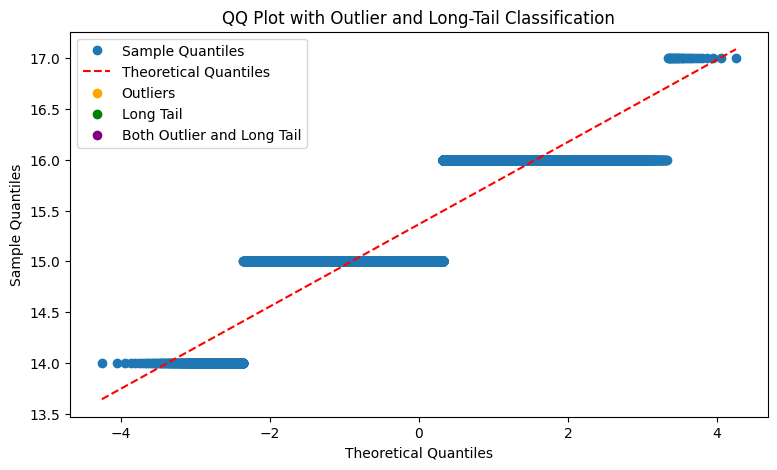

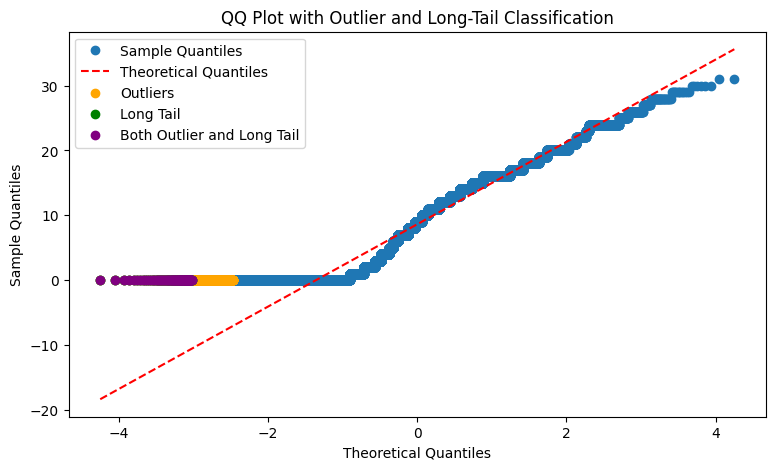

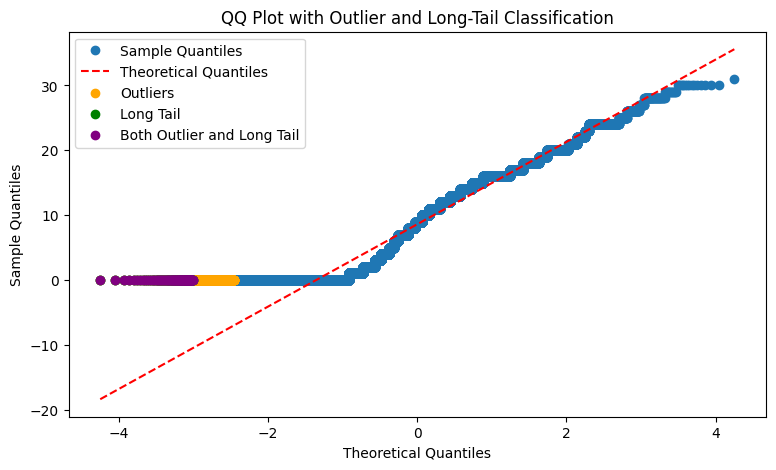

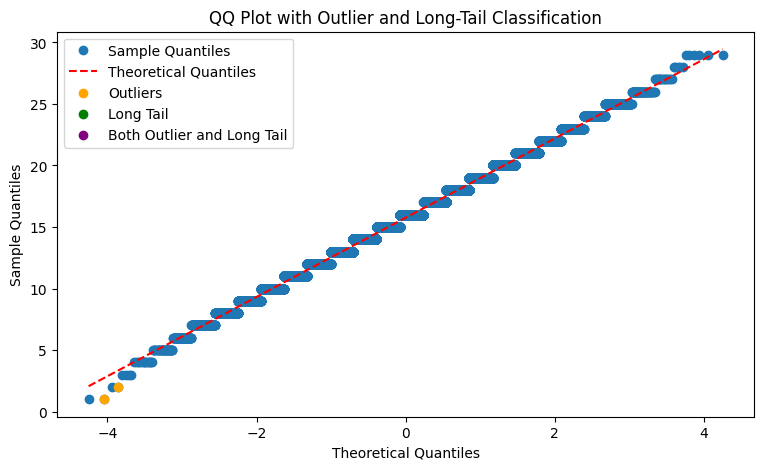

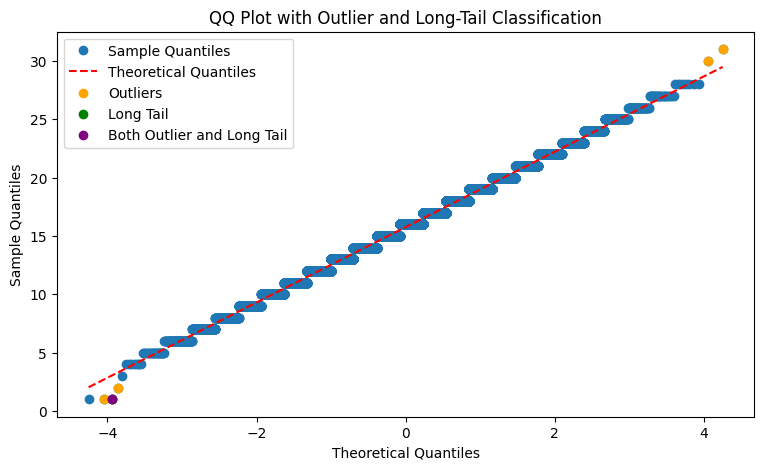

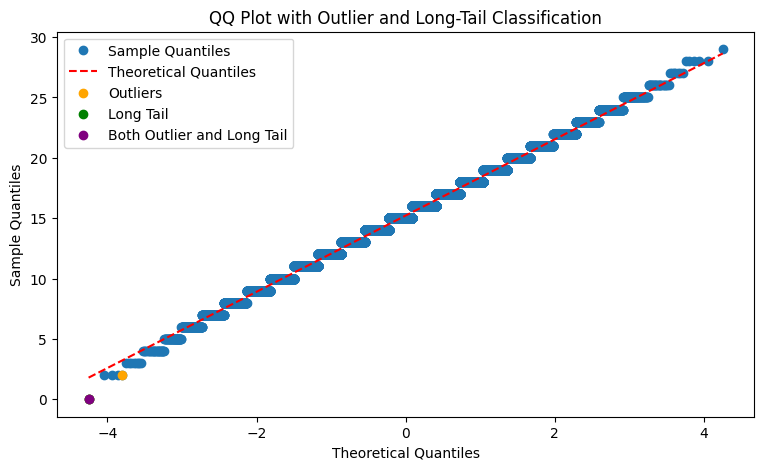

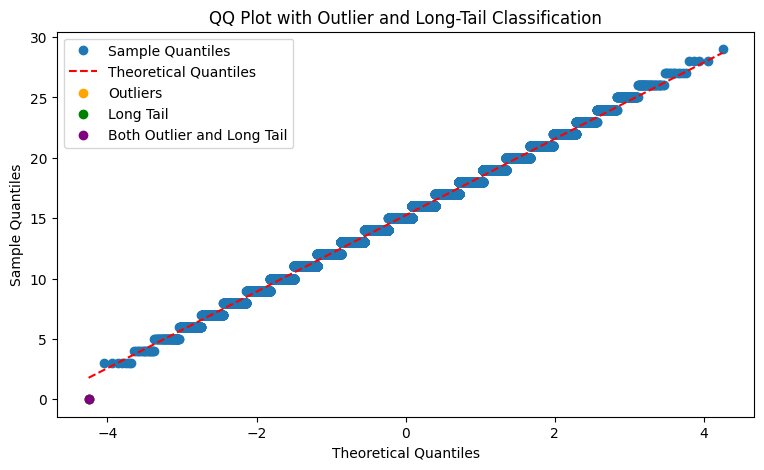

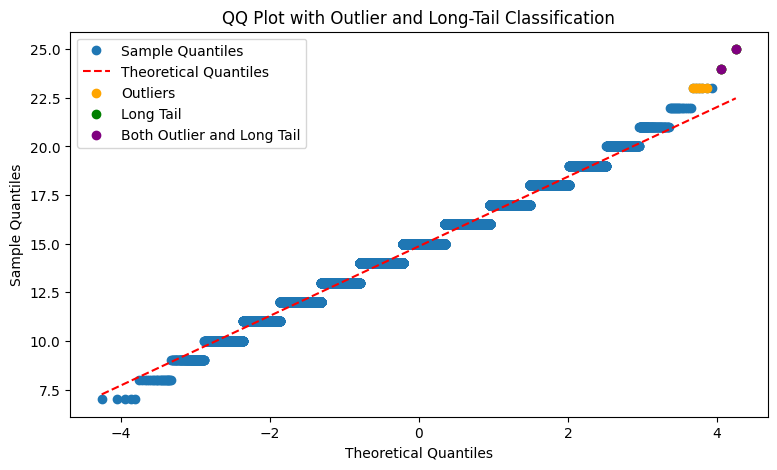

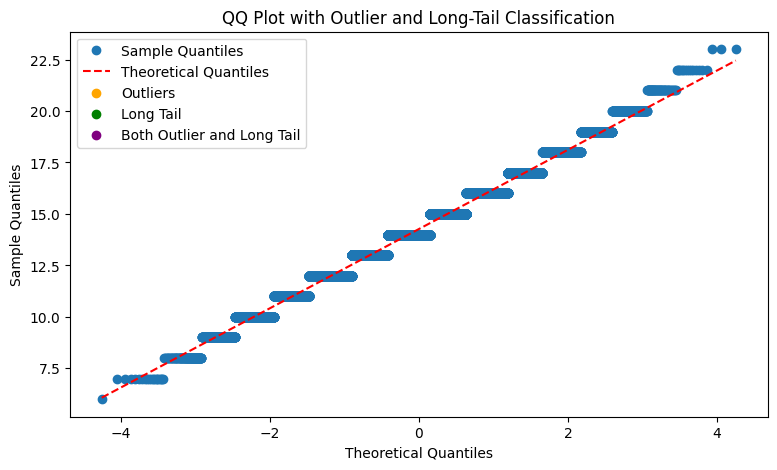

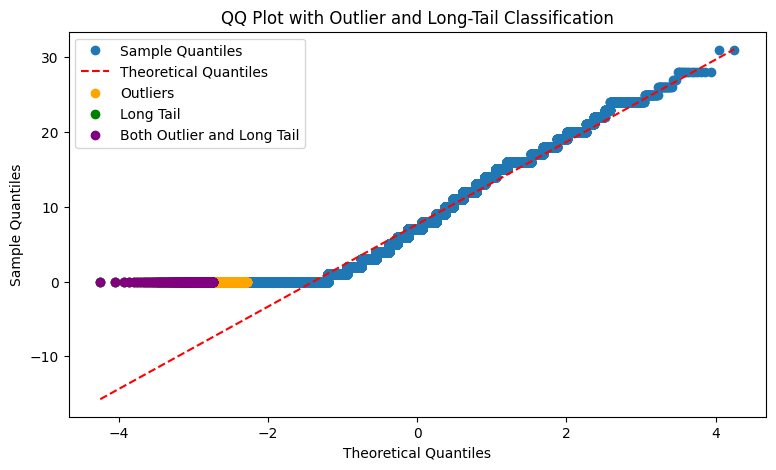

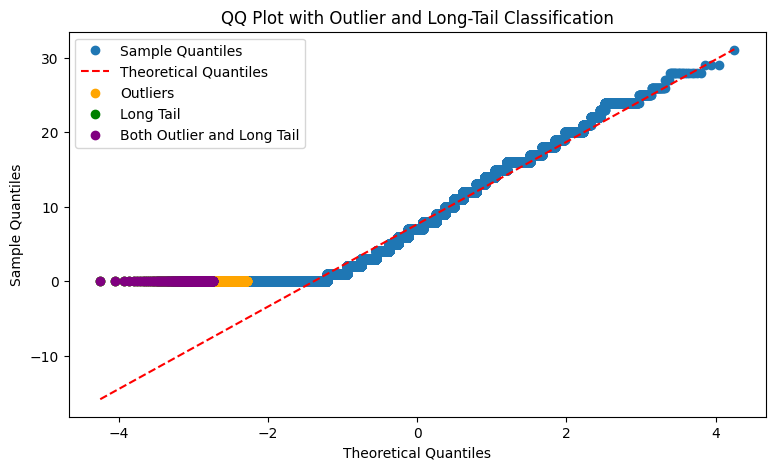

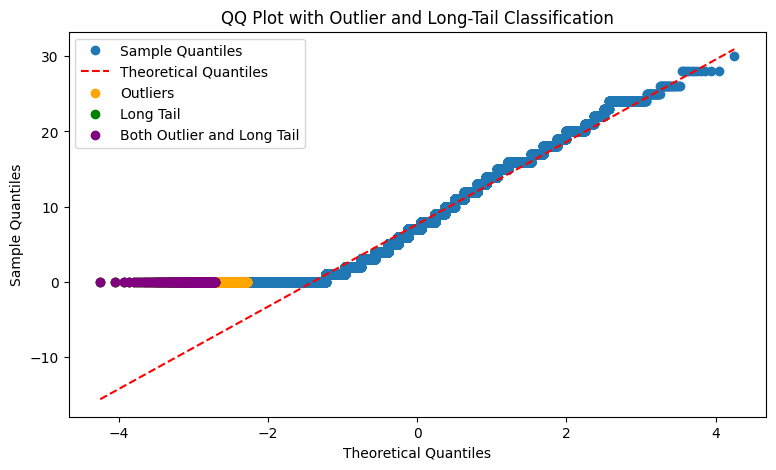

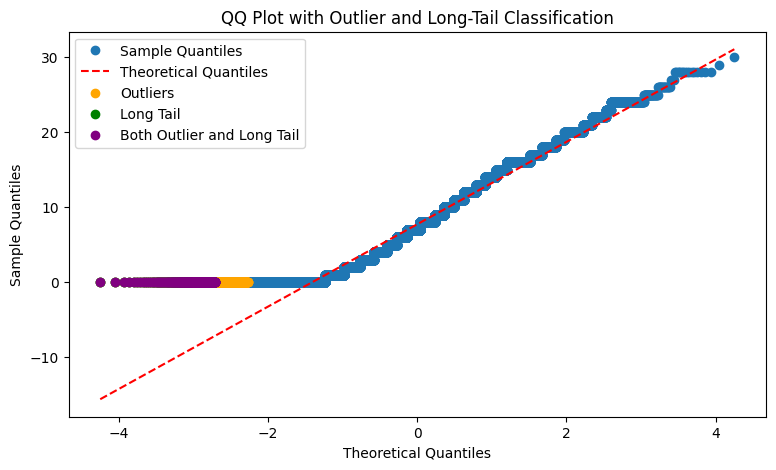

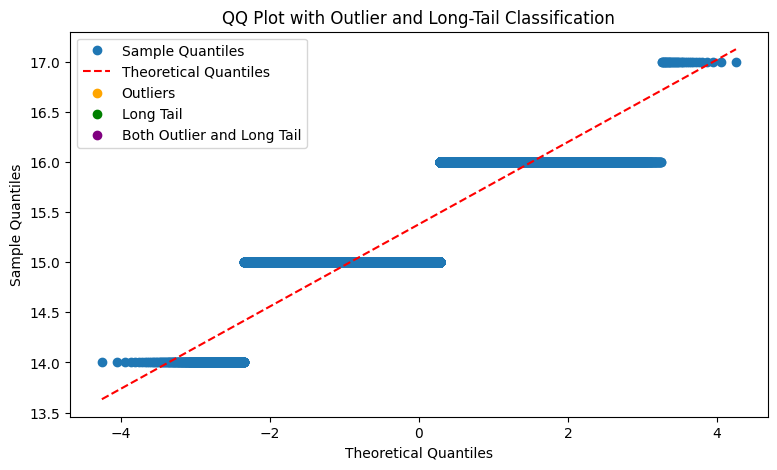

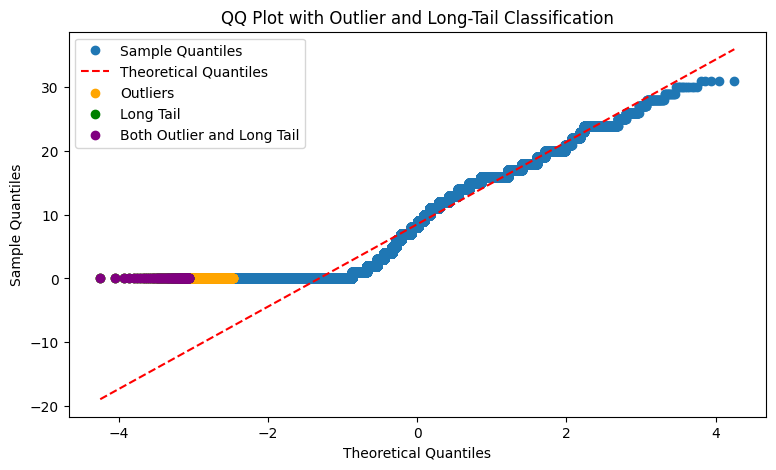

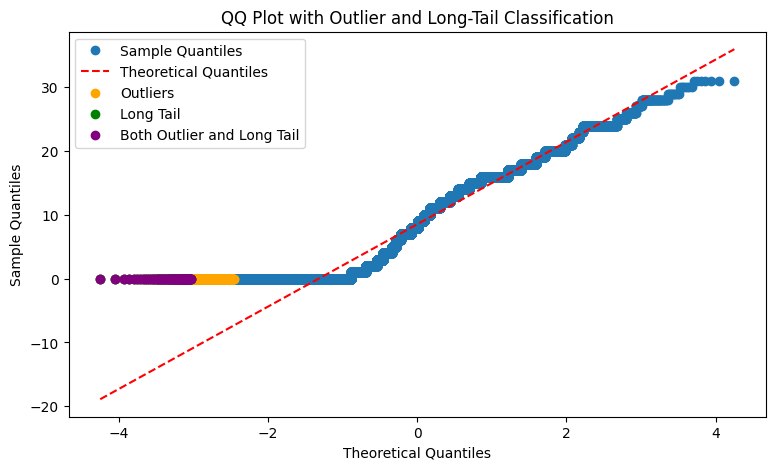

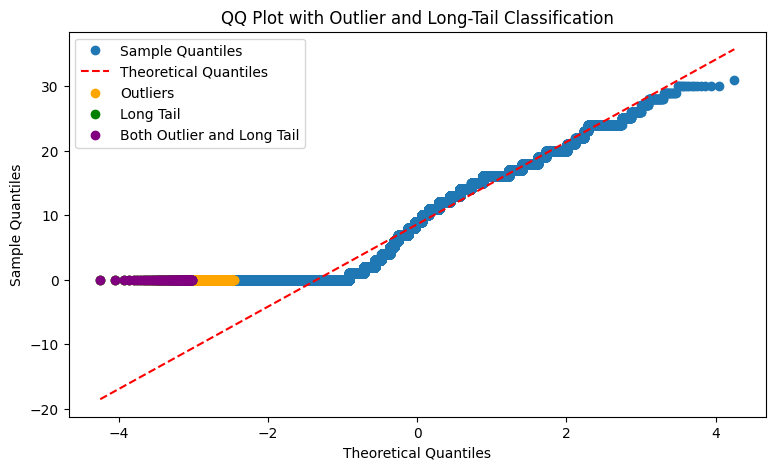

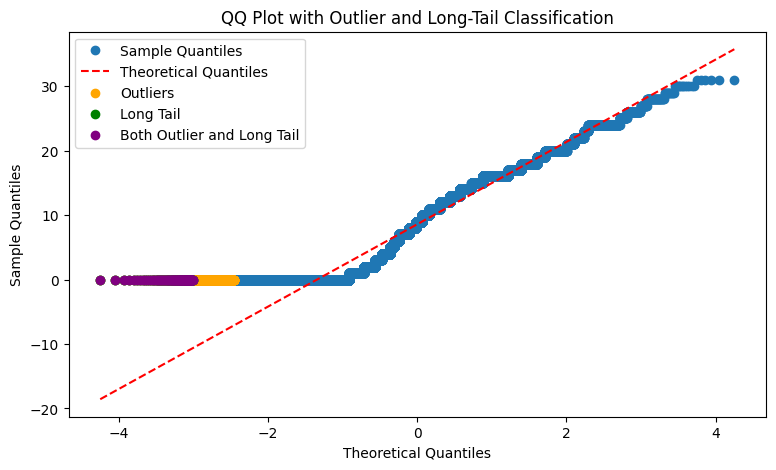

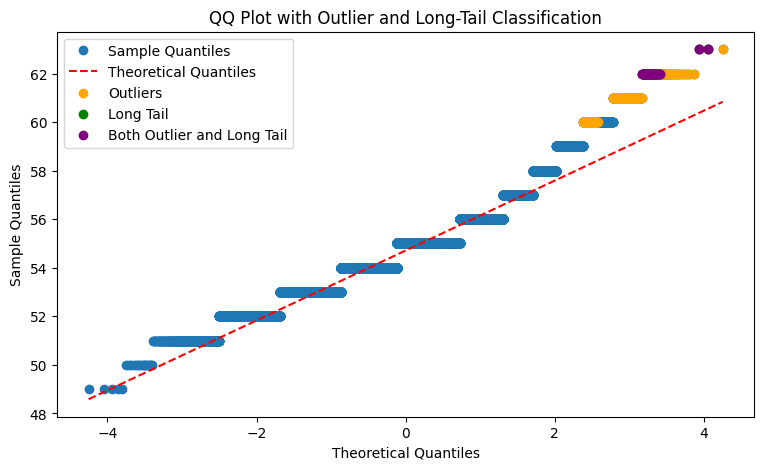

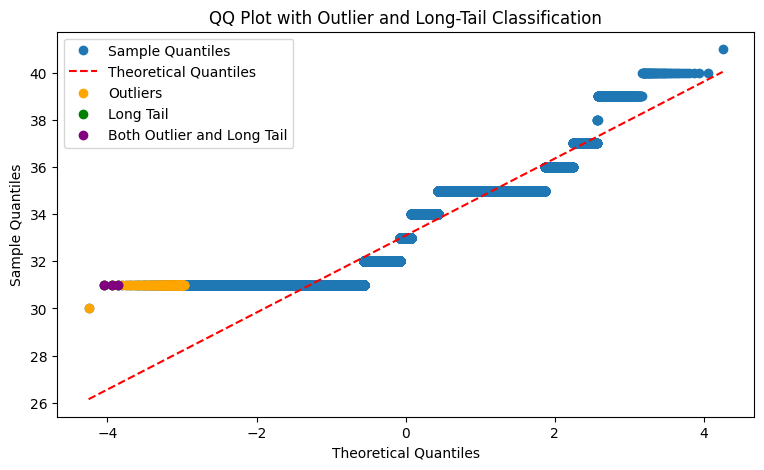

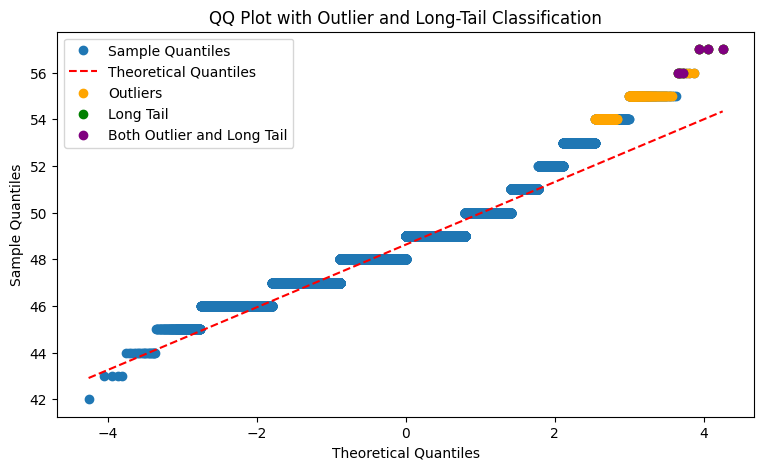

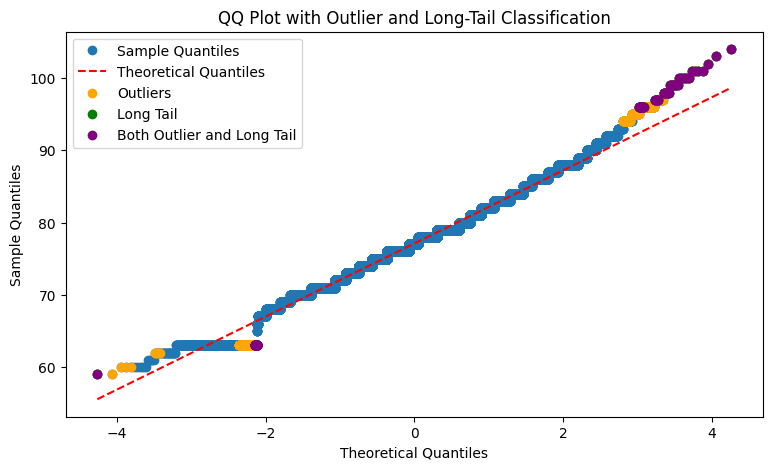

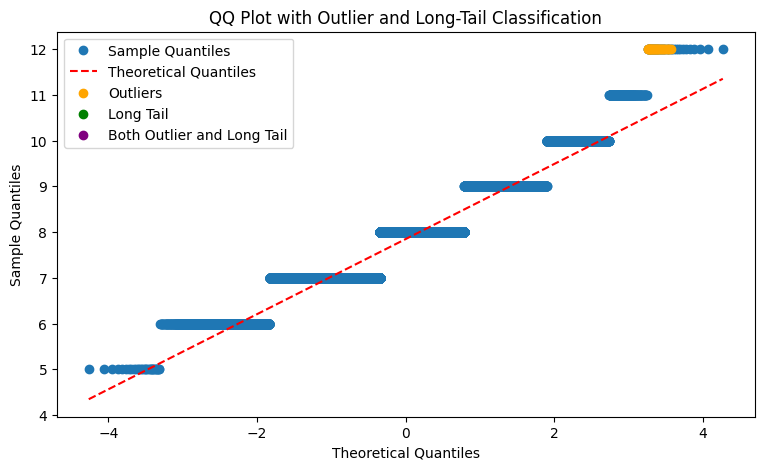

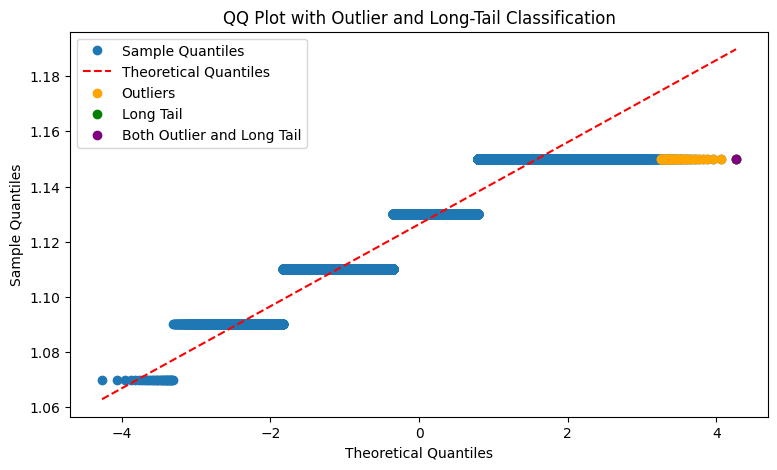

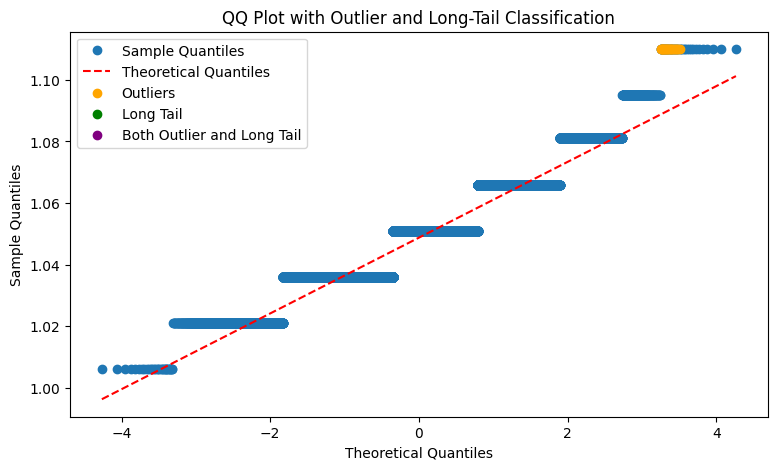

In [47]:
from sklearn.metrics import classification_report

yk_predictions = qq_predict(test, 0, 4, 6) # input outlier longtail thresholds 

#print(classification_report(yk_target, yk_predictions))

In [24]:
from sklearn.metrics import classification_report

ty_predictions = qq_predict(ty_values[2:], 0, 5, 5)

print(classification_report(ty_target, ty_predictions))

              precision    recall  f1-score   support

           0       1.00      0.24      0.39      1239
           1       0.15      1.00      0.26       163

    accuracy                           0.33      1402
   macro avg       0.57      0.62      0.32      1402
weighted avg       0.90      0.33      0.37      1402



In [ ]:
from sklearn.metrics import classification_report

best_f1_score = 0
best_recall = 0

thresholds = {"f1_threshold": 0, "recall_threshold": 0}

for i in range(0, 21, 2):
    threshold = i 
    predictions = qq_predict(ty_values[2:], threshold)
    report = classification_report(ty_target, predictions, output_dict=True)
    f1_score = report['1']['f1-score'] 
    recall = report['1']['recall'] 

    if f1_score > best_f1_score:
        best_f1_score = f1_score
        thresholds['f1_threshold'] = i

    if recall > best_recall:
        best_recall = recall
        thresholds['recall_threshold'] = i

print(thresholds)

{'f1_threshold': 20, 'recall_threshold': 0}


In [14]:
f1_thresholds = {"outlier_threshold": 0, "longtail_threshold": 0}
recall_thresholds = {"outlier_threshold": 0, "longtail_threshold": 0}
best_f1_score = 0
best_recall_score = 0

outlier_thresholds = np.linspace(0.1, 5.0, 5)
long_tail_thresholds = np.linspace(0.1, 5.0, 5)

for ot in outlier_thresholds:
    for lt in long_tail_thresholds:
        predictions = qq_predict(ty_values[2:], 0, ot, lt)
        report = classification_report(ty_target, predictions, output_dict=True)
        f1_score = report['1']['f1-score'] 
        recall = report['1']['recall'] 
        
        if f1_score > best_f1_score:
            best_f1_score = f1_score
            f1_thresholds = {"outlier_threshold": ot, "longtail_threshold": lt}

        if recall > best_recall_score:
            best_recall_score = recall
            recall_thresholds = {"outlier_threshold": ot, "longtail_threshold": lt}

print(f1_thresholds)  
print(recall_thresholds)                  

{'outlier_threshold': 5.0, 'longtail_threshold': 5.0}
{'outlier_threshold': 0.1, 'longtail_threshold': 0.1}


In [15]:
f1_thresholds = {"outlier_threshold": 0, "longtail_threshold": 0}
recall_thresholds = {"outlier_threshold": 0, "longtail_threshold": 0}
best_f1_score = 0
best_recall_score = 0

outlier_thresholds = np.linspace(0.1, 5.0, 5)
long_tail_thresholds = np.linspace(0.1, 5.0, 5)

for ot in outlier_thresholds:
    for lt in long_tail_thresholds:
        predictions = qq_predict(yk_values[2:], 0, ot, lt)
        report = classification_report(yk_target, predictions, output_dict=True)
        f1_score = report['1']['f1-score'] 
        recall = report['1']['recall'] 
        
        if f1_score > best_f1_score:
            best_f1_score = f1_score
            f1_thresholds = {"outlier_threshold": ot, "longtail_threshold": lt}

        if recall > best_recall_score:
            best_recall_score = recall
            recall_thresholds = {"outlier_threshold": ot, "longtail_threshold": lt}

print(f1_thresholds)  
print(recall_thresholds)    

{'outlier_threshold': 5.0, 'longtail_threshold': 5.0}
{'outlier_threshold': 0.1, 'longtail_threshold': 0.1}
